In [2]:
## supress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys
import wave
import math
import glob
import time
import random
import feather
import librosa
import subprocess
import librosa.display
import pretty_midi
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=5)
from matplotlib.mlab import find
from sklearn.decomposition import PCA
from scipy import signal
from bisect import bisect_left
from operator import itemgetter
from itertools import *
from pydub import AudioSegment

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before

def parabolic(f, x):
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def freq_from_autocorr(audio_signal, sr):
    """Estimate frequency using autocorrelation."""
    # Calculate autocorrelation (same thing as convolution, but with one input
    # reversed in time), and throw away the negative lags
    audio_signal -= np.mean(audio_signal)  # Remove DC offset
    corr = signal.fftconvolve(audio_signal, audio_signal[::-1], mode='full')
    corr = corr[len(corr)/2:]
    # Find the first low point
    d = np.diff(corr)
    try:
        start = find(d > 0)[0]
        # Find the next peak after the low point (other than 0 lag).  This bit is
        # not reliable for long signals, due to the desired peak occurring between
        # samples, and other peaks appearing higher.
        i_peak = np.argmax(corr[start:]) + start
        i_interp = parabolic(corr, i_peak)[0]
        freq = sr / i_interp
    except IndexError as e:
        # index could not be found, set the pitch to frequency 0
        freq = float('nan')
    
    # The voiced speech of a typical adult male will have a fundamental frequency 
    # from 85 to 180 Hz, and that of a typical adult female from 165 to 255 Hz.
    # Lowest Bass E2 (82.41Hz) to Soprano to C6 (1046.50Hz)
    
    # This number can be set with insight from the full dataset
    # if freq < 80 or freq > 1000:
    if freq < 100 or freq > 400:
        freq = float('nan')
        
    return freq

def load(filename, sr=8000):
    """
    Load a wave file and return the signal, sample rate and number of channels.
    Can be any format that libsndfile supports, like .wav, .flac, etc.
    """
    signal, sample_rate = librosa.load(filename, sr=sr)
    channels = 1
    return signal, sample_rate, channels

def analyse_pair(head, midi_filename, freq_func=freq_from_autocorr, num_windows=10, fs=8000, frame_size=256):
    """Analyse a single input example from the MIR-QBSH dataset."""
    # set parameters 
    # sampling rate of the data samples is 8kHz or 8000Hz 
    # ground truth frame size is at 256
    # can oversample for increased resolution

    ## Load data and label
    fileroot = head + '/' + midi_filename
    
    # Load the midi data as well
    midi_file = midiroot + midi_filename + '.mid'
    # print(midiroot)
#     midi_data = pretty_midi.PrettyMIDI(midi_file)
    midi_data = None 
    # print(midi_data)
    # think about alignment to midi_data.instruments[0].notes
    # currently alignment to true midi is NOT handled

    # load data
    audio_signal, _, _ = load(fileroot+'.wav', fs)
    # print('audio_signal', audio_signal)
    # print('length of audio_signal', len(audio_signal))

    # Load matching true labelled values
    # The .pv file contains manually labelled pitch file, 
    # with frame size = 256 and overlap = 0. 
    with open(fileroot+'.pv', 'r') as f:
        y = []
        for line in f:
            if float(line) > 0:
                y.append(float(line))
            else:
                y.append(float('nan'))
    # length of the true pitch values should match 
    # the number of audio frames to analyse
    # print('length of true pitch values', len(y))

    size_match = len(y) == len(audio_signal)/frame_size
    # print('size match', size_match)

    num_frames = len(audio_signal) / frame_size
    # print('num_frames', num_frames)

    # extract pitches (candidates), y_hat

    # allow for window overlap to handle clean transitions
    # solve for num_frames * 4 and then average out for clean sample
    window_size = frame_size / num_windows
    y_hat_freq = []
    for n in range(num_frames):
        window_freq = []
        for i in range(num_windows):
            window_start = 0+n*frame_size+i*window_size
            window_end = frame_size+n*frame_size+i*window_size
            window_s = audio_signal[window_start:window_end]

            # this is where the magic happens
            # define the function to extract the frequency from the windowed signal
            window_freq.append(freq_func(window_s, fs))
        
        # append the median of the window frequencies, 
        # somewhat robust to anomalies
        y_hat_freq.append(np.median(window_freq))

    # TODO(kory): downsample to the same length as the ground truth
    
    # One approach is to remove the outlier points by eliminating any 
    # points that were above (Mean + 2*SD) and any points below (Mean - 2*SD) 
    # before plotting the frequencies. This can not happen on the frequency itself
    # and rather happens on the frequency change, thus smoothing out huge leaps
    freq_change = np.abs(np.diff(y_hat_freq))
    
    # remove any points where the frequency change is drastic
    freq_mean = np.nanmean(freq_change)
    freq_std = np.nanstd(freq_change)
    freq_change_max = freq_mean + freq_std
    bad_idx = np.argwhere(freq_change > freq_change_max).flatten()
    for i in bad_idx:
        y_hat_freq[i] = float('nan')
    
    # Convert the frequencies to midi notes
    y_hat = librosa.hz_to_midi(y_hat_freq)

    # print('y_hat', y_hat)
    # print('length of estimated pitch values', len(y_hat))

    # compare pitches with actual labels, y
    squared_error = (y-y_hat)**2
    absolute_error = abs(y-y_hat)
    mse = np.nanmean(squared_error)
    mae = np.nanmean(absolute_error)
    # print('MSE', mse)
    
    # create a version of the frequency distribution with no nans
    y_hat_freq_no_nan = [value for value in y_hat_freq if not math.isnan(value)]
    
    # clean up the pitches
    clean_y_hat = cleaned_midi_pitches(y_hat)    
    return audio_signal, midi_data, y, y_hat, clean_y_hat, y_hat_freq, y_hat_freq_no_nan, squared_error, mse, absolute_error, mae

def save_extracted_pitches(clean_y_hat, fname, reconroot=None, fs=8000, frame_size=256):
    # TODO(korymath): save the extracted pitches and output midi
    
    # Save the extraced pitches 
    np.savetxt(fname + '.out', clean_y_hat, delimiter=',')
    
    # Save the midi rendition
    # Create a PrettyMIDI object
    song_recon = pretty_midi.PrettyMIDI()
    
    # Create an Instrument instance
    instrument_name = 'Voice Oohs' # 'Voice Oohs' 'Glockenspiel', 'Acoustic Grand Piano'
    instrument_program = pretty_midi.instrument_name_to_program(instrument_name)
    instrument = pretty_midi.Instrument(program=instrument_program)
        
    # get the real indecies
    real_idx = np.argwhere(~np.isnan(clean_y_hat))

    # find groups of real valued signals
    consecutive_real = []
    for k, g in groupby(enumerate(real_idx.flatten()), lambda (i,x):i-x):
        consecutive_real.append(map(itemgetter(1), g))

    # initialize the note holding arrays
    start_times = []
    end_times = []
    pitches = []
    velocities = []
    
    time_per_step = float(frame_size / (fs * 1.0)) # 0.032 

    for group in consecutive_real:
        # only build note if it exists for longer than a single step
        if len(group) > 1:
            start = group[0] * time_per_step
            start_times.append(start)
            end_times.append(start + len(group) * time_per_step)
            pitches.append(clean_y_hat[group[0]])
            # can pull a dynamic velocity from the amplitude of the wave
            velocities.append(110)

    for i in range(len(pitches)):
        note = pretty_midi.Note(velocity=velocities[i], pitch=int(pitches[i]), 
                                start=start_times[i], 
                                end=end_times[i])
        # print(note)
        # append the note to the instrument
        instrument.notes.append(note)
            
    # Add the instrument to the PrettyMIDI object
    song_recon.instruments.append(instrument)
    
    # Write out the MIDI data
    if reconroot is not None:
        revised_file_name = '-'.join(fname.split('/')[3:])[:-4] + '-' + instrument_name.replace(" ", "_") + '.recon.mid'
    else:
        revised_file_name = fname + '-' + instrument_name.replace(" ", "_") + '.recon.mid'
        reconroot = ''
    
    print reconroot + revised_file_name
    song_recon.write(reconroot + revised_file_name)
    
    midi_f = reconroot + revised_file_name
    wav_f = reconroot + revised_file_name[:-4] + '.wav'
    
    ## save as a wav file for easy comparison
    subprocess.call(['timidity', midi_f, '-Ow', '-o', wav_f])
    
    # TODO(korymath): save overlayed midi pitch synth with original wav file
    # sound1 = AudioSegment.from_file(fname)
    # sound2 = AudioSegment.from_file(wav_f)
    # played_togther = sound1.overlay(sound2)
    # sound1.export(reconroot + revised_file_name[:-4] + '_combination.wav')
    
    # TODO(korymath): attempt to lock to the most prominent key
    # Compute the relative amount of each semitone across the entire song, a proxy for key
    # total_velocity = sum(sum(cello_c_chord.get_chroma()))
    # relative_semitones = [sum(semitone)/total_velocity for semitone in cello_c_chord.get_chroma()]

    # keys = ["C","C#/Db","D","D#/Eb","E","F","F#/Gb","G","G#/Ab","A","A#/Bb","B"]
    # # print('key:', keys[np.argmax(relative_semitones)])

    # notes = {}
    # notes['C'] = [60,62,64,65,67,69,71,72]

    # for note in cello_c_chord.instruments[0].notes:
    #     note.pitch = takeClosest(notes['C'], note.pitch)

    # # Write out the MIDI data
    # cello_c_chord.write(fname + '.cello-key-of-C.mid')

    return song_recon

def cleaned_midi_pitches(old_y_hat):
    # find NaN gaps of 1 and infill
    # find larger NaN gaps and create segments
    # use median in segment to define note
    # use length of segment to define note duration

    # initialize our recovery midi pitches
    y_hat_clean = np.copy(old_y_hat)

    # get indecies of nan values
    nan_idx = np.argwhere(np.isnan(y_hat_clean))

    # interpolate over single nans 
    consecutive_nans = []
    for k, g in groupby(enumerate(nan_idx.flatten()), lambda (i,x):i-x):
        consecutive_nans.append(map(itemgetter(1), g))

    for group in consecutive_nans:
        if len(group) == 1:
            # print('single nan at ', group[0])
            if (group[0] == 0):
                y_hat_clean[group[0]] = y_hat_clean[group[0]+1]
            elif (group[0] == len(y_hat_clean) - 1):
                y_hat_clean[group[0]] = y_hat_clean[group[0]-1]
            else:
                # print(group[0], len(y_hat_clean))
                y_hat_clean[group[0]] = ((y_hat_clean[group[0]+1])+(y_hat_clean[group[0]-1]))/2
            # print(group[0], y_hat_clean[group[0]])

    # get idx of real valued signals
    real_idx = np.argwhere(~np.isnan(y_hat_clean))

    # find groups of real valued signals
    consecutive_real = []
    for k, g in groupby(enumerate(real_idx.flatten()), lambda (i,x):i-x):
        consecutive_real.append(map(itemgetter(1), g))
    # for each group, the median is a good estimate of the midi pitch class
    for group in consecutive_real:
        # TODO(korymath): could be the mean? 
        # find the median of the real note group
        y_hat_clean[group] = np.median(y_hat_clean[group])
    return y_hat_clean


In [4]:
# 1. Load the data in to training samples X and labels y
# 2. Split the data into training, testing and validation
# 3. Test the naive model (autocorrelation) on the test set, this is the baseline to beat
# 3a. Evaluation metric is pitch value MSE compared to groundtruth
# 4. Train a new model, compare with naive model

# Data: Roger Jang's MIR-QBSH corpus which is comprised of 8kHz
# 4431 queries along with 48 ground-truth MIDI files. 
# All queries are from the beginning of references. 
# Manually labeled pitch for each recording is available. 
# hand labels are more important to match than ground truth
# multiclass classification example

# build the filenames incrementally
# may need to change based on the location of the datasets
reconroot = 'Dataset/MIR-QBSH-corpus/recon/'
wavroot = 'Dataset/MIR-QBSH-corpus/waveFile/'
midiroot = 'Dataset/MIR-QBSH-corpus/midiFile/'

# build a list of all the subjects
subjects = []
for dirpath, dirnames, filenames in os.walk(wavroot):
    if not dirnames:
        subjects.append(str(dirpath) + '/')

print('number of subjects:', len(subjects))
        
# build a dictionary to collect the errors
errors = {}

# build an array to visualize frequency distribtion over all samples
y_hat_freq_no_nan_all = []

# set the function to extract the fundamental frequency
freq_func = freq_from_autocorr

# for each subject
#for subject in tqdm(subjects):
for subject in subjects[0:3]:
    # get a list of files this subject has recorded
    files = glob.glob(subject + "*.wav")

    # analyse the given audio signal file
    # for f in tqdm(files):
    for f in files[0:3]:
        errors[f] = {}
        # split the given file into filename head and tail 
        head, tail = os.path.split(f)
        # midi_filename gives midi_file reference for each nested sample wav/pv pair
        midi_filename = tail.split('.')[0]
        (audio_signal, midi_data, y, y_hat, clean_y_hat, y_hat_freq, 
         y_hat_freq_no_nan, squared_error, mse, absolute_error, 
         mae) = analyse_pair(head, midi_filename, freq_func=freq_func, 
                             num_windows=4, fs=8000, frame_size=256)
        
        # save extracted pitches, midi and wav
        song_recon = save_extracted_pitches(clean_y_hat, f, reconroot, fs=8000, frame_size=256)
        
        # extend the frequency list out
        y_hat_freq_no_nan_all.extend(y_hat_freq_no_nan)

        # Store error metrics in errors dictionary
        errors[f]['mse'] = mse
        errors[f]['mae'] = mae
        errors[f]['filename'] = '/'.join(f.split('/')[-3:])
        # print(f, mse)
    
    # Print the running error mean
    error_accumulator = 0
    for k,v in errors.iteritems():
        error_accumulator += v['mae']
    print('Subject:', subject)
    print('Mean MAE so far', error_accumulator/len(errors))

print('Done processing samples')

('number of subjects:', 195)
Dataset/MIR-QBSH-corpus/recon/year2003-person00001-00013-Voice_Oohs.recon.mid
Dataset/MIR-QBSH-corpus/recon/year2003-person00001-00014-Voice_Oohs.recon.mid
Dataset/MIR-QBSH-corpus/recon/year2003-person00001-00016-Voice_Oohs.recon.mid
('Subject:', 'Dataset/MIR-QBSH-corpus/waveFile/year2003/person00001/')
('Mean MAE so far', 0.21465206573023246)
Dataset/MIR-QBSH-corpus/recon/year2003-person00002-00012-Voice_Oohs.recon.mid
Dataset/MIR-QBSH-corpus/recon/year2003-person00002-00013-Voice_Oohs.recon.mid
Dataset/MIR-QBSH-corpus/recon/year2003-person00002-00014-Voice_Oohs.recon.mid
('Subject:', 'Dataset/MIR-QBSH-corpus/waveFile/year2003/person00002/')
('Mean MAE so far', 0.27894590293614169)
Dataset/MIR-QBSH-corpus/recon/year2003-person00003-00012-Voice_Oohs.recon.mid
Dataset/MIR-QBSH-corpus/recon/year2003-person00003-00013-Voice_Oohs.recon.mid
Dataset/MIR-QBSH-corpus/recon/year2003-person00003-00014-Voice_Oohs.recon.mid
('Subject:', 'Dataset/MIR-QBSH-corpus/waveFil

In [5]:
# get some summary statistics from Pandas
df = pd.DataFrame.from_dict(errors, orient='index')
# a pitch difference of 1Hz is perceptable to the human ear
# http://hyperphysics.phy-astr.gsu.edu/hbase/Sound/earsens.html
# thus, want to get the mean absolute error below 1Hz

# TODO(korymath): check this fact?
# what is the average jump in a midi pitch class?

# store the processing of the current experiment
current_milli_time = int(round(time.time() * 1000))
path = 'analysis/' + str(current_milli_time) + '.feather'
feather.write_dataframe(df, path)

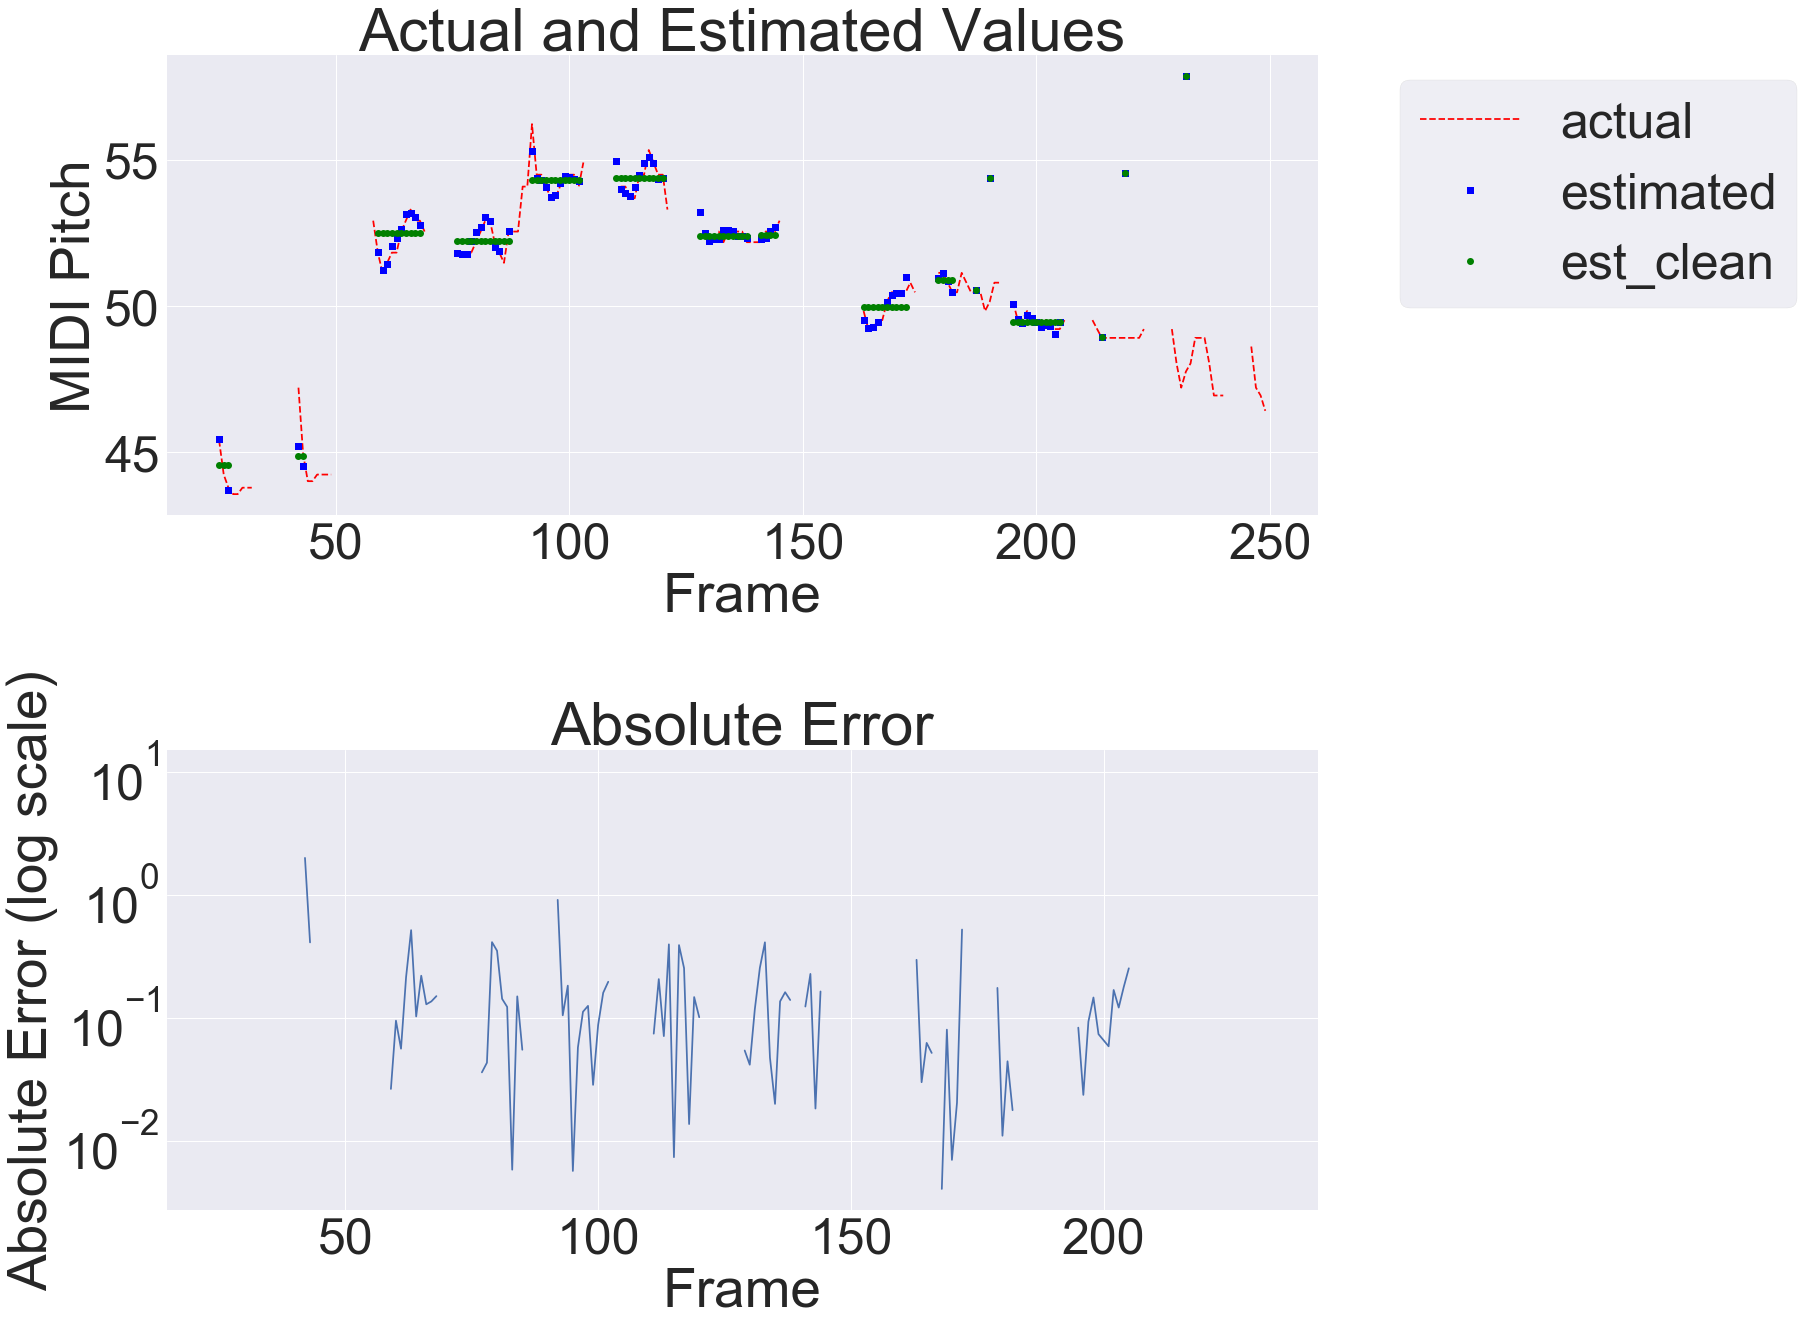

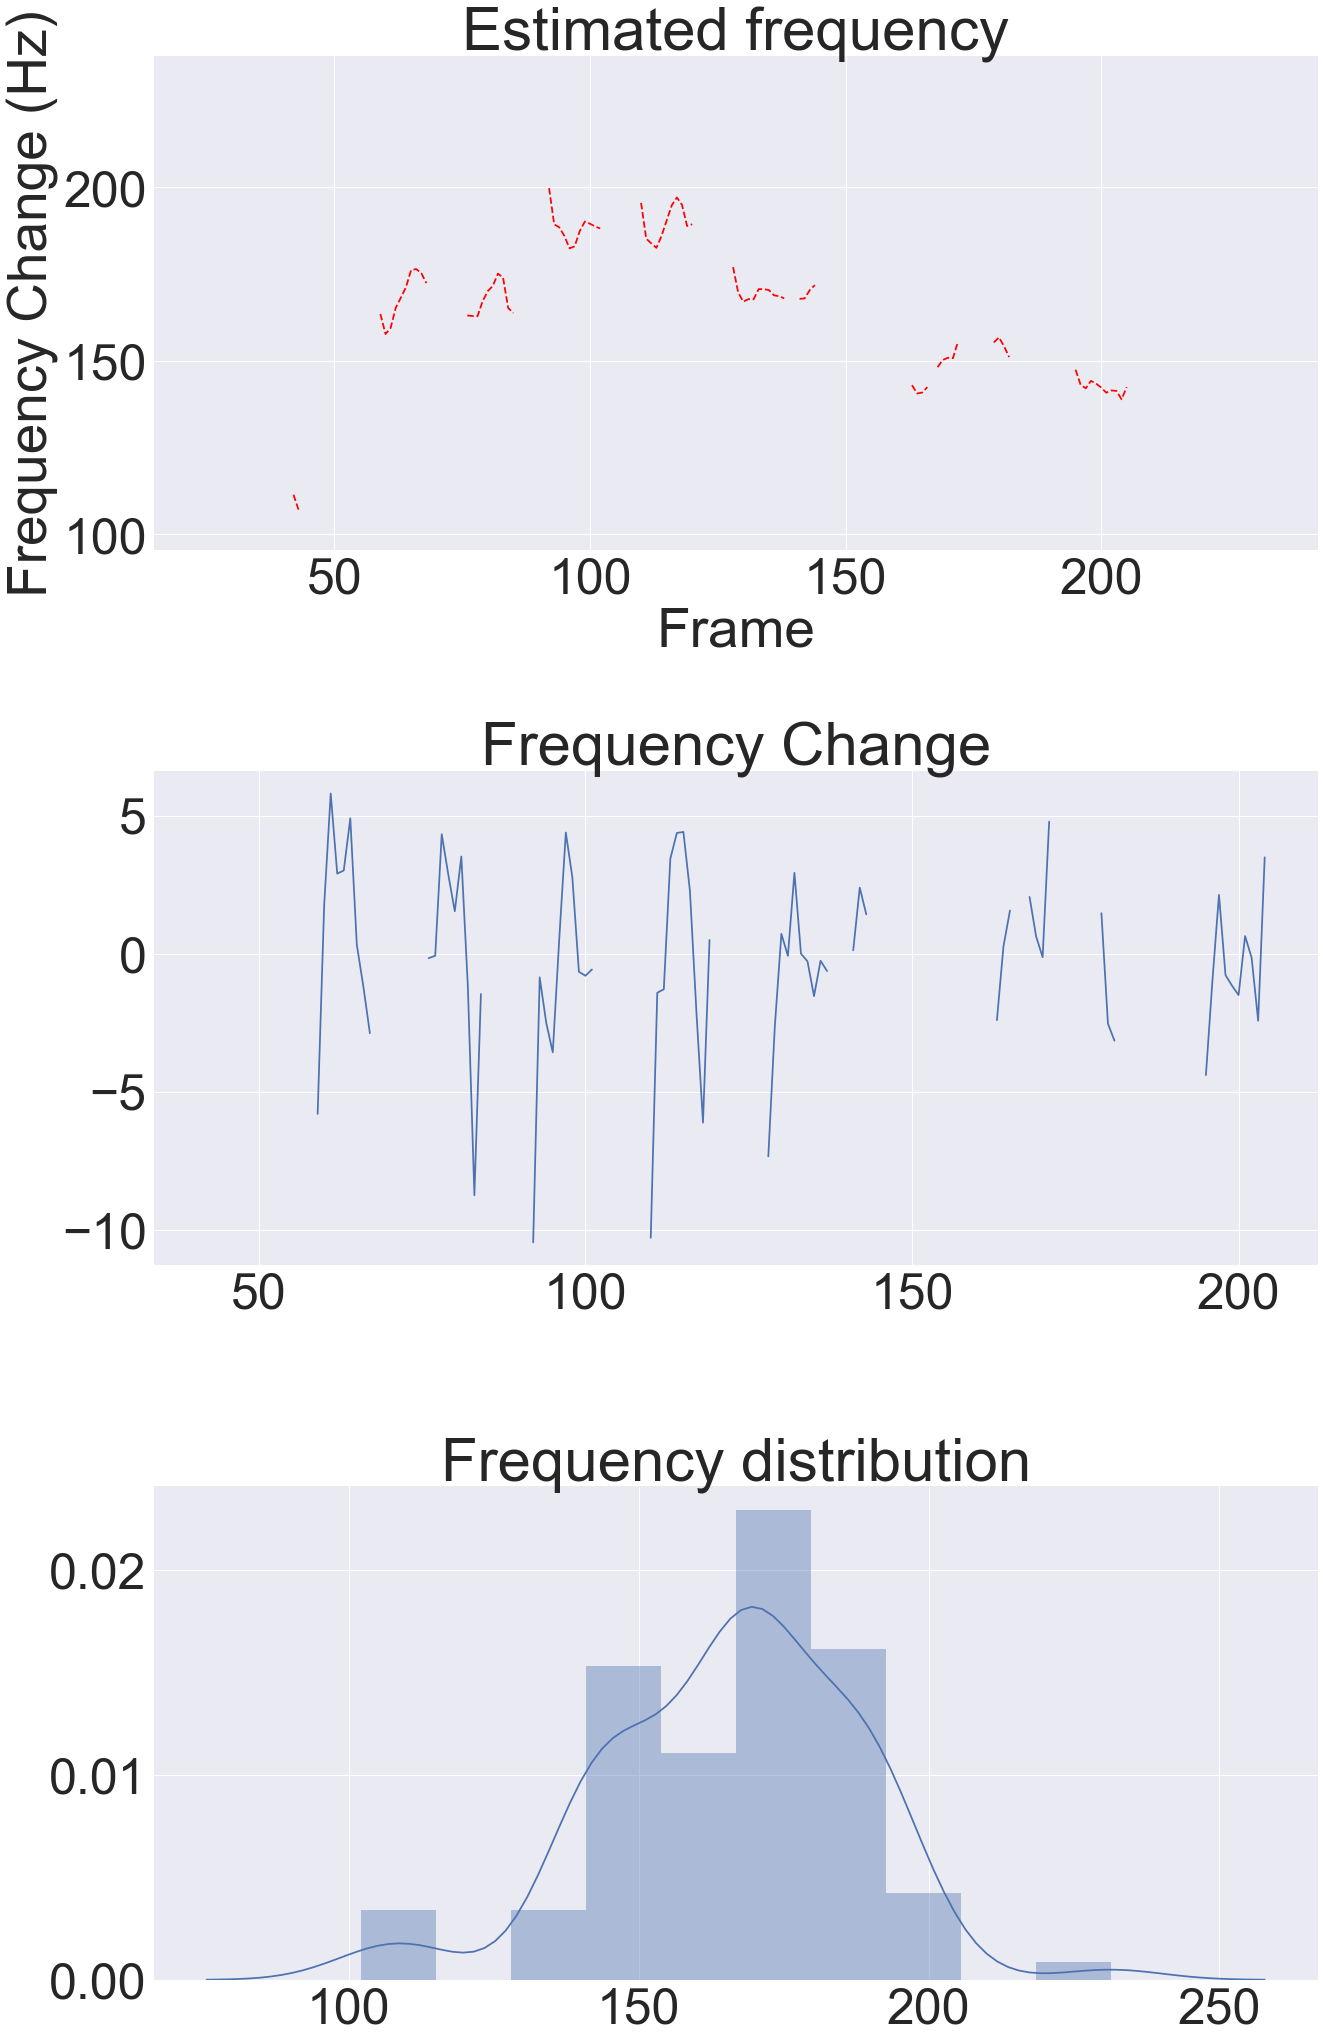

In [6]:
# Visualize the errors between the estimated and ground truth 
# plot the pitches extracted against the ground truth labels
# evenly sampled time at 200ms intervals
t = np.arange(0., 250., 1)
f, (ax1, ax2) = plt.subplots(2, figsize=(20,20))

# plot actual and estimates
ax1.tick_params(axis='both', which='major')
ax1.plot(t, y, 'r--')
ax1.plot(t, y_hat, 'bs')
# ax1.plot(t, np.round(y_hat), 'go')
ax1.plot(t, clean_y_hat, 'go')
ax1.set_title('Actual and Estimated Values')
ax1.set(xlabel='Frame', ylabel='MIDI Pitch') 
ax1.legend(["actual", "estimated", "est_clean"], loc=2, bbox_to_anchor=(1.05, 1), frameon=True)

# Plot square errors
ax2.plot(absolute_error)
ax2.set_title('Absolute Error')
ax2.set(xlabel='Frame', ylabel='Absolute Error (log scale)') 
ax2.set_yscale('log')

# tighten up and show
plt.tight_layout()
plt.show()

# Visualize the estimated frequencies, and the frequency histogram
f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20,30))

# plot estimated frequencies
ax1.tick_params(axis='both', which='major')
ax1.plot(t, y_hat_freq, 'r--')
ax1.set_title('Estimated frequency')
ax1.set(xlabel='Frame', ylabel='Frequency (Hz)')

ax2.set_title('Frequency Change')
freq_change = np.diff(y_hat_freq)
ax2.plot(t[:-1], freq_change)
ax1.set(xlabel='Frame', ylabel='Frequency Change (Hz)') 

# plot frequency histogram
ax3.set_title('Frequency distribution')
sns.distplot(y_hat_freq_no_nan, ax=ax3)

# tighten up and show
plt.tight_layout()
plt.show()

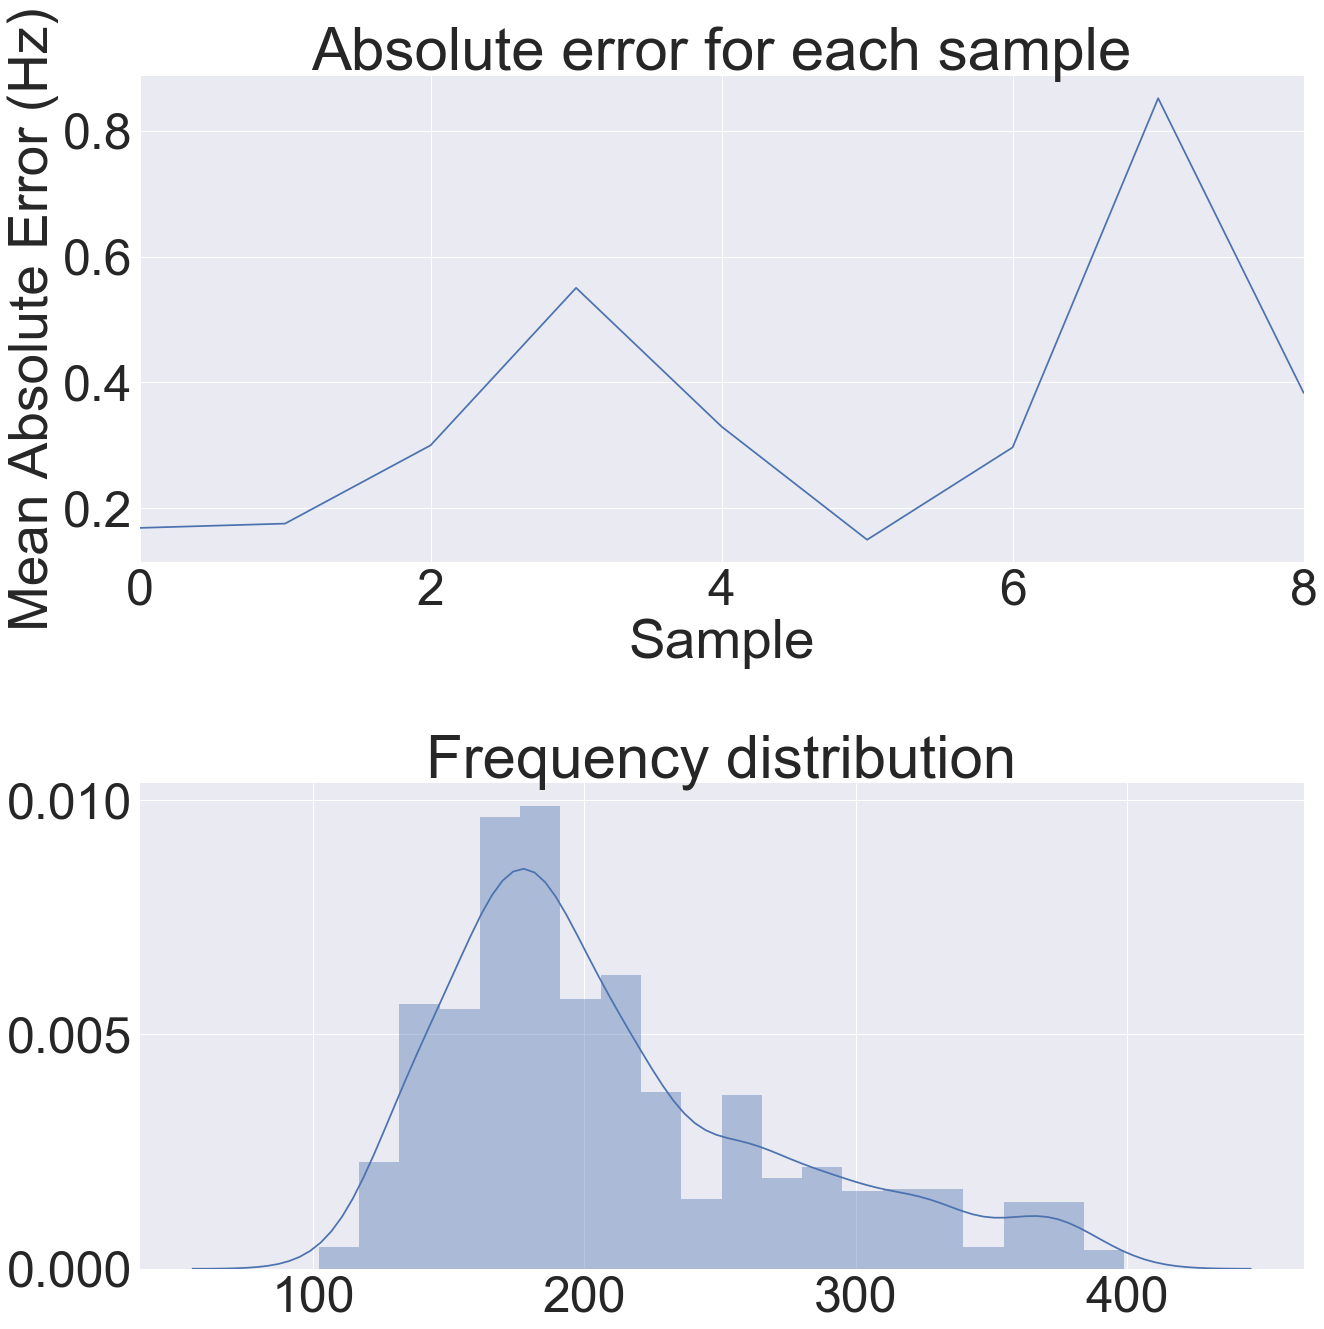

In [7]:
# test reading in the saved error dataframe
df = feather.read_dataframe(path)

# Visualize the full experimental set statistics
f, (ax1, ax2) = plt.subplots(2, figsize=(20,20))

# plot estimated frequencies
ax1.tick_params(axis='both', which='major')
df['mae'].plot(ax=ax1)
ax1.set_title('Absolute error for each sample')
ax1.set(xlabel='Sample', ylabel='Mean Absolute Error (Hz)') 

# plot frequency histogram
ax2.set_title('Frequency distribution')
sns.distplot(y_hat_freq_no_nan_all, ax=ax2)

# tighten up and show
plt.tight_layout()
plt.show()

In [8]:
# Worst 10 transcriptions
# Error rate
print('Error rate', 100.0 * len(df[df['mae'] > 1]) / len(df[df['mae'] < 1]))
df.sort_values(by='mae', ascending=False).head(10)

('Error rate', 0.0)


,mse,mae,filename
7,8.159480,0.851857,year2003/person00003/00013.wav
3,4.551081,0.550318,year2003/person00002/00012.wav
8,1.809385,0.383304,year2003/person00003/00014.wav
4,1.919608,0.329658,year2003/person00002/00013.wav
2,0.495130,0.299926,year2003/person00001/00016.wav
6,0.714728,0.296628,year2003/person00003/00012.wav
1,0.062833,0.175441,year2003/person00001/00014.wav
0,0.126267,0.168589,year2003/person00001/00013.wav
5,0.053780,0.149743,year2003/person00002/00014.wav


('length of estimated pitch values', 214)
Dataset/testing-sounds/canadian_national_anthem_recording2.wav-Voice_Oohs.recon.mid


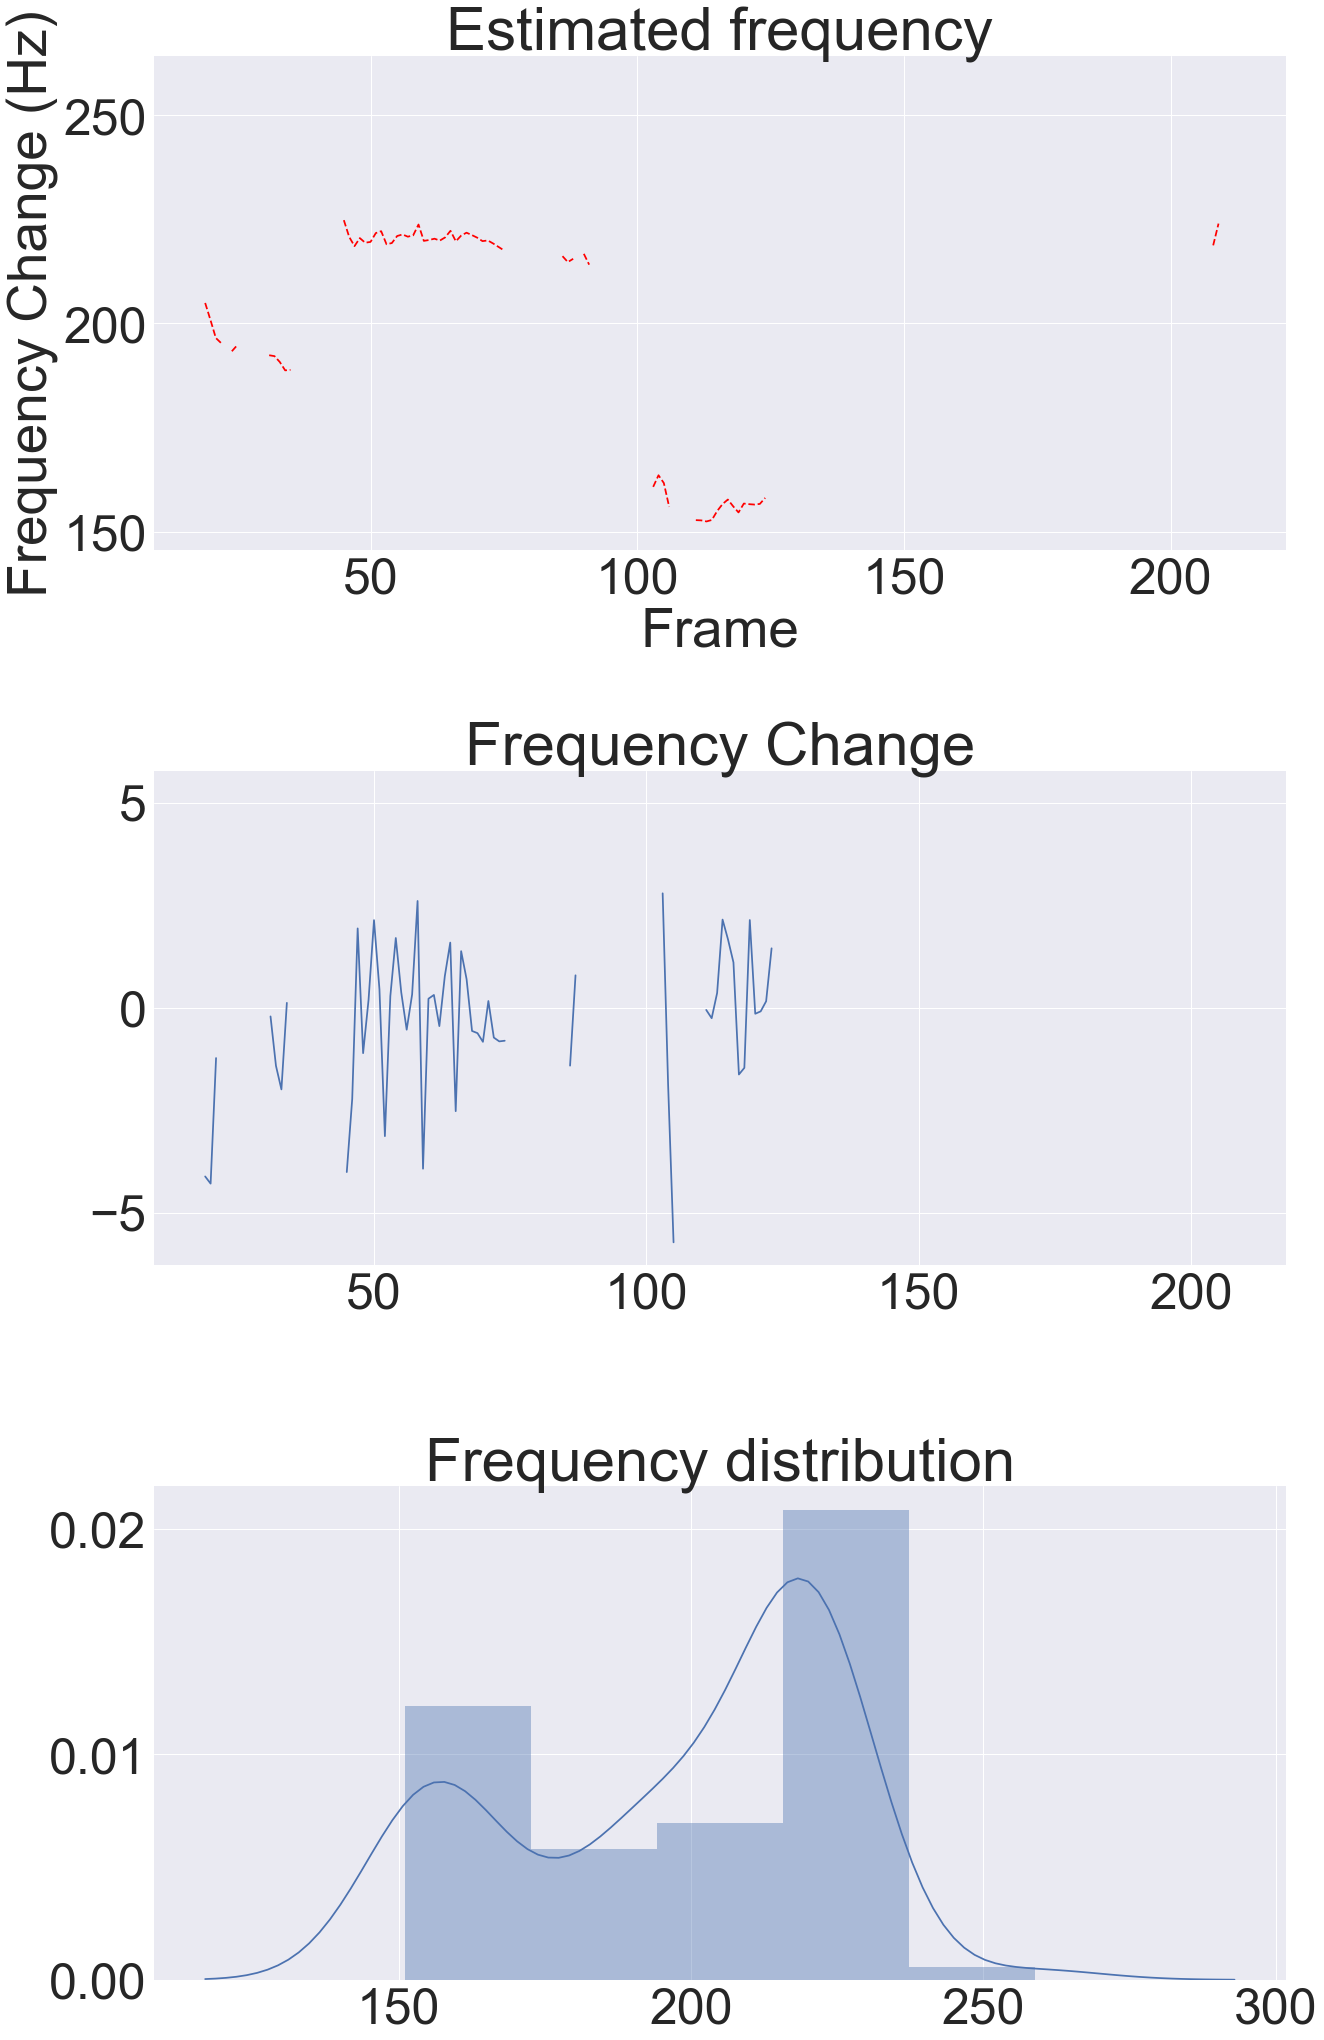

In [9]:
## stand alone single file processing

num_windows = 10
frame_size = 1024
fs = 44100
# fname = 'Dataset/testing-sounds/test-death-2.wav'
# fname = 'Dataset/testing-sounds/canadian_national_anthem_recording.wav'
fname = 'Dataset/testing-sounds/canadian_national_anthem_recording2.wav'
audio_signal, _, _ = load(fname, fs)
num_frames = len(audio_signal) / frame_size
# print('num_frames', num_frames)

# extract pitches (candidates), y_hat

# allow for window overlap to handle clean transitions
# solve for num_frames * 4 and then average out for clean sample
window_size = frame_size / num_windows
y_hat_freq = []
for n in range(num_frames):
    window_freq = []
    for i in range(num_windows):
        window_start = 0+n*frame_size+i*window_size
        window_end = frame_size+n*frame_size+i*window_size
        window_s = audio_signal[window_start:window_end]

        # this is where the magic happens
        # define the function to extract the frequency from the windowed signal
        window_freq.append(freq_func(window_s, fs))

    # append the median of the window frequencies, 
    # somewhat robust to anomalies
    y_hat_freq.append(np.median(window_freq))

# One approach is to remove the outlier points by eliminating any 
# points that were above (Mean + 2*SD) and any points below (Mean - 2*SD) 
# before plotting the frequencies. This can not happen on the frequency itself
# and rather happens on the frequency change, thus smoothing out huge leaps
freq_change = np.abs(np.diff(y_hat_freq))

# remove any points where the frequency change is drastic
freq_mean = np.nanmean(freq_change)
freq_std = np.nanstd(freq_change)
freq_change_max = freq_mean + freq_std
bad_idx = np.argwhere(freq_change > freq_change_max).flatten()
for i in bad_idx:
    y_hat_freq[i] = float('nan')

# Convert the frequencies to midi notes
y_hat = librosa.hz_to_midi(y_hat_freq)

print('length of estimated pitch values', len(y_hat))

# create a version of the frequency distribution with no nans
y_hat_freq_no_nan = [value for value in y_hat_freq if not math.isnan(value)]

# clean up the pitches
clean_y_hat = cleaned_midi_pitches(y_hat)   
song_recon = save_extracted_pitches(clean_y_hat, fname=fname, fs=fs, frame_size=frame_size)

# # Visualize the estimated frequencies, and the frequency histogram
# f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20,30))

# # time on x-axis
# t = np.arange(0., len(y_hat_freq), 1)

# # plot estimated frequencies
# ax1.tick_params(axis='both', which='major')
# ax1.plot(t, y_hat_freq, 'r--')
# ax1.set_title('Estimated frequency')
# ax1.set(xlabel='Frame', ylabel='Frequency (Hz)')

# ax2.set_title('Frequency Change')
# freq_change = np.diff(y_hat_freq)
# ax2.plot(t[:-1], freq_change)
# ax1.set(xlabel='Frame', ylabel='Frequency Change (Hz)') 

# # plot frequency histogram
# ax3.set_title('Frequency distribution')
# sns.distplot(y_hat_freq_no_nan, ax=ax3)

# # tighten up and show
# plt.tight_layout()
# plt.show()

In [10]:
#@title Notebook

# TODO: alignment to true midi
# start to investigate true midi alignment
# obviously most of these are going to be poorly aligned

# instrument = midi_data.instruments[0]
# true_midi_pitches = []
# for note in instrument.notes:    
#     note_duration = int((note.end - note.start) * 10)
#     true_midi_pitches.extend([note.pitch] * note_duration)
    
# len(true_midi_pitches)

# plt.plot(true_midi_pitches)
# plt.plot(y)
# plt.show()

In [ ]:
# initialize note trackers for construction
#    last_note = 0
#     note_number = 0
#    note_hold_duration = 0
#    starting_time = 0
#     for i in range(1, len(clean_y_hat)):        
#         # Handle the NaN case
#         if y_hat[i] != y_hat[i]:
#             note_number = 0
#         else:
#             # Round to the nearest midi pitch patch
#             note_number = np.round(y_hat[i])
        
#         # set the last note
#         if y_hat[i-1] != y_hat[i-1]:
#             last_note = 0
                                           
#         # if this note is the same as the last note, add to the duration
#         # frame size is 256, recorded at 8kHz
#         # each note in y_hat corresponds to 0.032 seconds
#         # this means that MOST samples at ~8s
#         if note_number == last_note:
#             note_hold_duration += 0.032
#             # print(i, 'holding', int(note_number), note_hold_duration)
#         else:
#             # Create a Note instance for this note
#             note = pretty_midi.Note(velocity=100, 
#                                     pitch=int(last_note), 
#                                     start=starting_time, 
#                                     end=starting_time+note_hold_duration)
#             # print('current note', note_number, 'last note', last_note)
#             # print(i, 'writing', int(last_note), starting_time, starting_time+note_hold_duration)
            
#             # Add it to our cello instrument
#             cello.notes.append(note)
#             # set the starting time of the next note
#             starting_time += note_hold_duration
#             # reset the note_hold_duration
#             note_hold_duration = 0
#             # update the last note
#             last_note = note_number